# <center>Exercise 4 Stock Price Prediction</center>

**Objectives**
- Predict stock price by Linear Regression. Taking Alibaba history price as an example to go through the practice.
- Add new features based on historical price data for better prediction performance.
- Evaluate Linear Regresion performance through metrics like accuracy, mean squared error, mean absolute error.
- Visualize prediction vs. the actual.

**Data Source** : The Professor


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_ta as ta

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## 1 DATA UNDERSTANDING

**Load Data**

In [3]:
df = pd.read_csv("Alibaba.csv")
df

,date,open,high,low,close,volume
0,2014-09-19,92.7000,99.7000,89.95,93.89,271879400
1,2014-09-22,92.7000,92.9500,89.50,89.89,66332498
2,2014-09-23,88.9400,90.4800,86.62,87.17,38861975
3,2014-09-24,88.4700,90.5700,87.22,90.57,31864232
4,2014-09-25,91.0900,91.5000,88.50,88.92,28526179
...,...,...,...,...,...,...
1808,2021-11-23,136.0320,136.8499,133.31,133.66,24058183
1809,2021-11-24,133.1000,136.7600,131.22,136.52,19956216
1810,2021-11-26,132.9300,133.9804,131.22,133.35,14814898
1811,2021-11-29,134.2500,134.5500,130.55,131.61,18613945


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813 entries, 0 to 1812
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1813 non-null   object 
 1   open    1813 non-null   float64
 2   high    1813 non-null   float64
 3   low     1813 non-null   float64
 4   close   1813 non-null   float64
 5   volume  1813 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 85.1+ KB


>Notes:
>- The data type of "date" is incorrect. Will convert it to datetime64.

**Convert the data type of "date" to datetime64.**

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813 entries, 0 to 1812
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1813 non-null   datetime64[ns]
 1   open    1813 non-null   float64       
 2   high    1813 non-null   float64       
 3   low     1813 non-null   float64       
 4   close   1813 non-null   float64       
 5   volume  1813 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 85.1 KB


**Set date as the index of each record.**

In [7]:
df = df.set_index("date") 

**Check if any missing values.**

In [8]:
df.isna().sum().sum()

0

>Note:
>- There is no missing values.

**Check if any duplicates.**</br>
It is shown there is no duplicates.

In [9]:
df.duplicated().sum().sum()

0

>Note:
>- There is no duplicated records.

**Plot Alibaba's Close Price**</br>
This is the historical data.

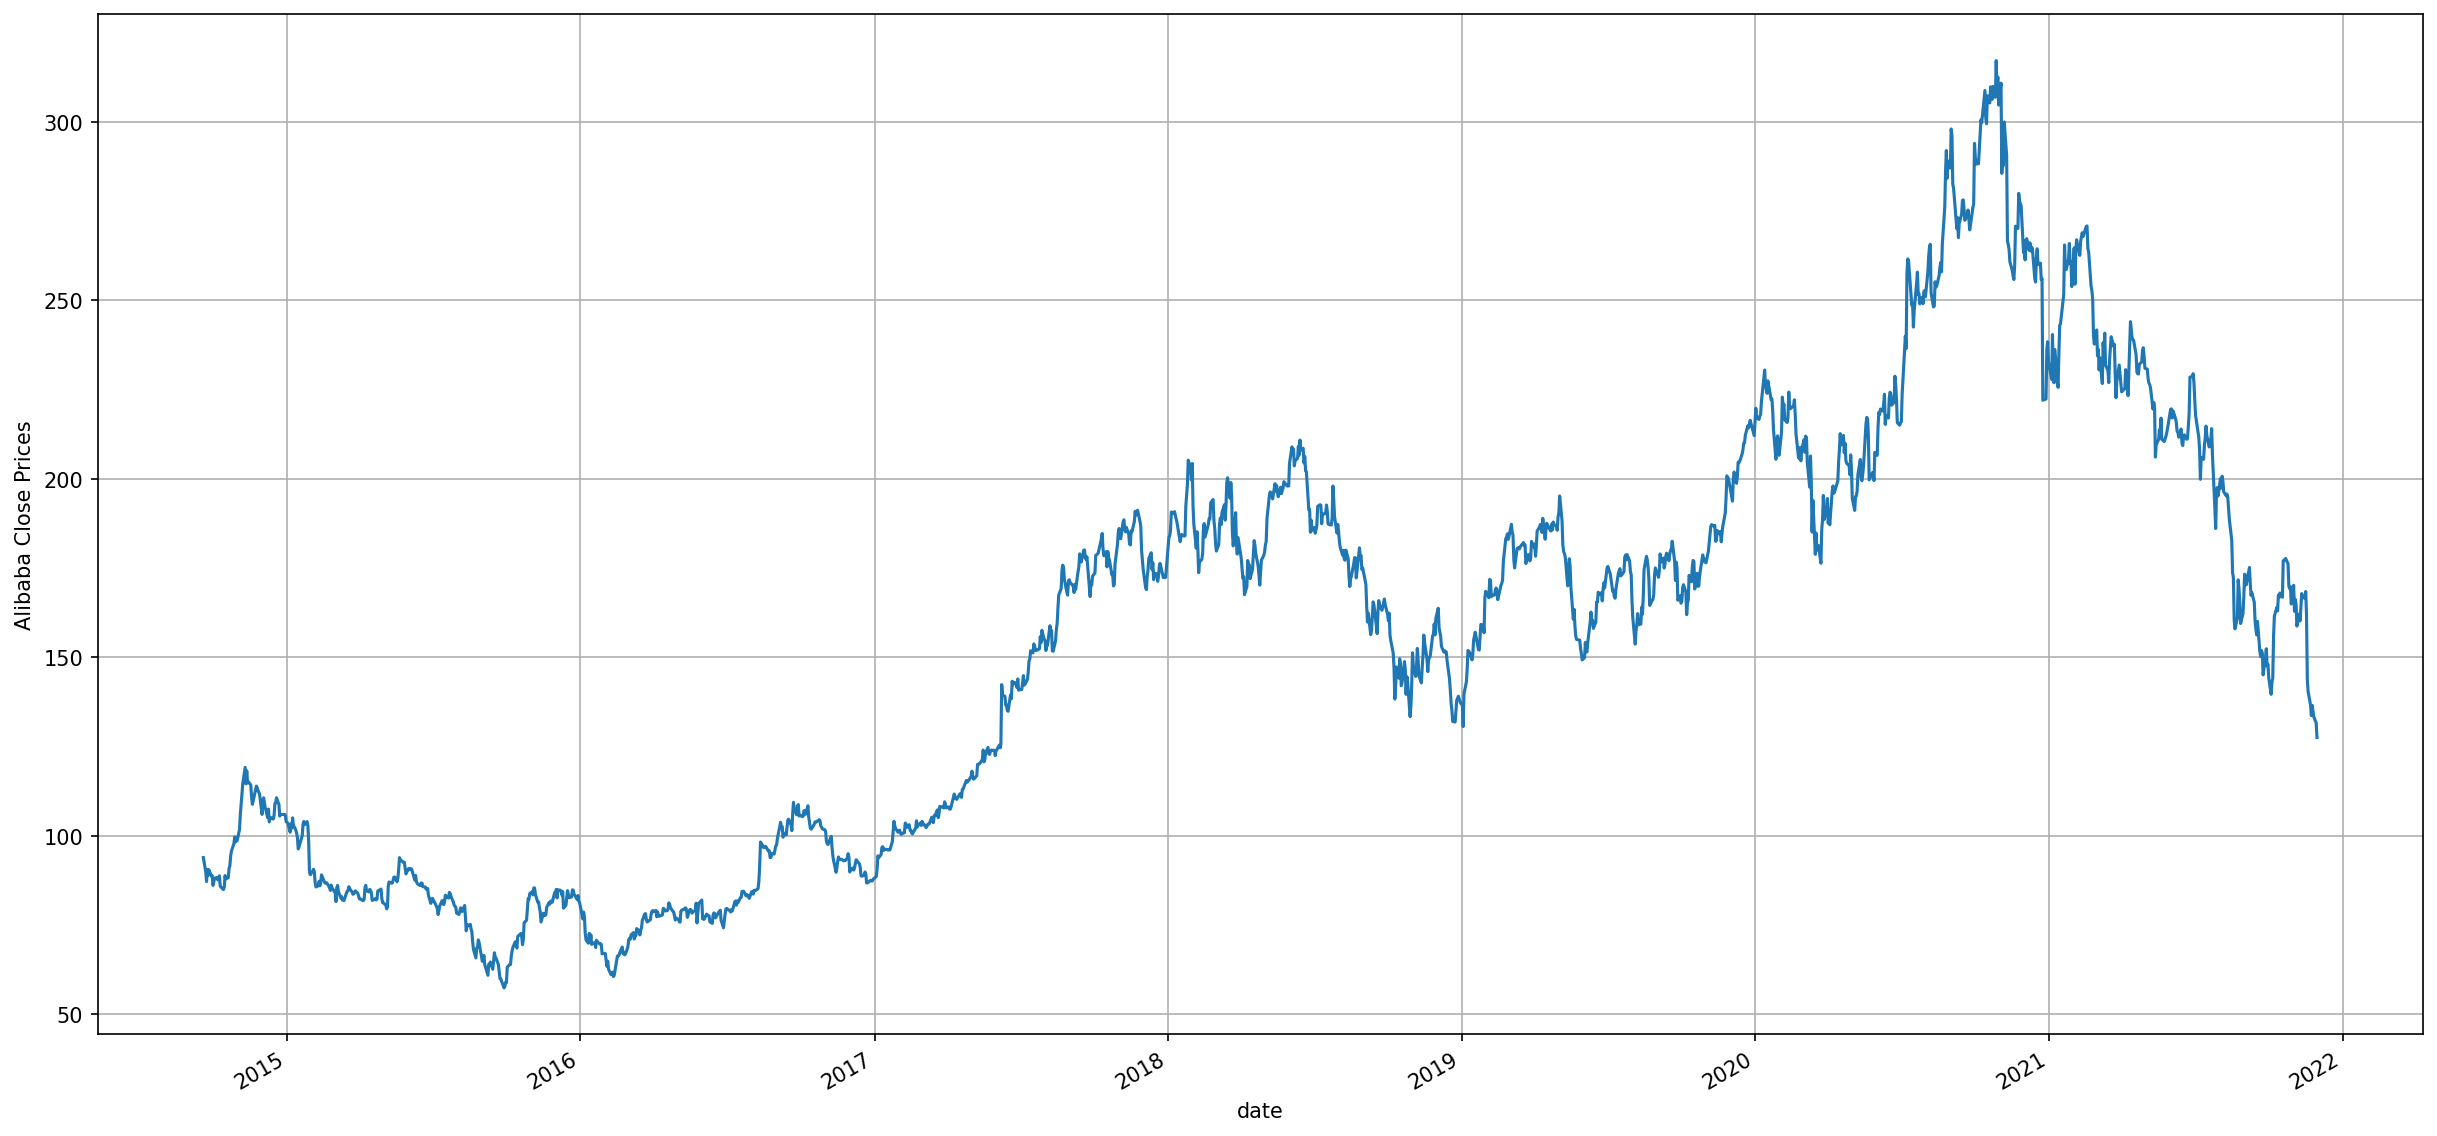

In [10]:
plt.figure(figsize=(20,10), dpi=150)

df.close.plot()
plt.ylabel('Alibaba Close Prices')

plt.grid()
plt.show()

## 2 DATA PREPROCESSING

### Add X-day EMA & X-day return signal as new features

In [11]:
# EMA
df['ema3'] = ta.ema(df.close, length=3)
df['ema5'] = ta.ema(df.close, length=5)
df['ema10'] = ta.ema(df.close, length=10)
df['ema20'] = ta.ema(df.close, length=20)

# Return
df['r1'] = np.where(df['close'] > df['close'].rolling(window=1).mean(), 1, -1)
df['r3'] = np.where(df['close'] > df['close'].rolling(window=3).mean(), 1, -1)
df['r5'] = np.where(df['close'] > df['close'].rolling(window=5).mean(), 1, -1)
df['r10'] = np.where(df['close'] > df['close'].rolling(window=10).mean(), 1, -1)

df

,open,high,low,close,volume,ema3,ema5,ema10,ema20,r1,r3,r5,r10
date,,,,,,,,,,,,,
2014-09-19,92.7000,99.7000,89.95,93.89,271879400,NaN,NaN,NaN,NaN,-1,-1,-1,-1
2014-09-22,92.7000,92.9500,89.50,89.89,66332498,NaN,NaN,NaN,NaN,-1,-1,-1,-1
2014-09-23,88.9400,90.4800,86.62,87.17,38861975,90.316667,NaN,NaN,NaN,-1,-1,-1,-1
2014-09-24,88.4700,90.5700,87.22,90.57,31864232,90.443333,NaN,NaN,NaN,-1,1,-1,-1
2014-09-25,91.0900,91.5000,88.50,88.92,28526179,89.681667,90.088000,NaN,NaN,-1,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-23,136.0320,136.8499,133.31,133.66,24058183,137.781627,142.465160,150.040069,156.358906,-1,-1,-1,-1
2021-11-24,133.1000,136.7600,131.22,136.52,19956216,137.150813,140.483440,147.581874,154.469487,-1,1,-1,-1
2021-11-26,132.9300,133.9804,131.22,133.35,14814898,135.250407,138.105627,144.994261,152.458107,-1,-1,-1,-1


In [12]:
df = df.dropna()
df

,open,high,low,close,volume,ema3,ema5,ema10,ema20,r1,r3,r5,r10
date,,,,,,,,,,,,,
2014-10-16,84.9800,89.1750,84.0150,88.85,15216307,87.210955,86.914323,87.192117,88.161500,-1,1,1,1
2014-10-17,90.4000,90.9000,87.6701,87.91,17360731,87.560477,87.246215,87.322641,88.137548,-1,1,1,1
2014-10-20,88.0000,89.5000,87.8600,88.26,9861999,87.910239,87.584143,87.493070,88.149210,-1,-1,1,1
2014-10-21,89.1000,92.5000,88.5000,90.90,23207990,89.405119,88.689429,88.112512,88.411190,-1,1,1,1
2014-10-22,92.2500,93.5000,91.0100,91.63,20331868,90.517560,89.669619,88.752055,88.717743,-1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-23,136.0320,136.8499,133.3100,133.66,24058183,137.781627,142.465160,150.040069,156.358906,-1,-1,-1,-1
2021-11-24,133.1000,136.7600,131.2200,136.52,19956216,137.150813,140.483440,147.581874,154.469487,-1,1,-1,-1
2021-11-26,132.9300,133.9804,131.2200,133.35,14814898,135.250407,138.105627,144.994261,152.458107,-1,-1,-1,-1


### Define X & y

In [13]:
X = df[['ema3', 'ema5','ema10','ema20','r1','r3','r5', 'r10']]
X

,ema3,ema5,ema10,ema20,r1,r3,r5,r10
date,,,,,,,,
2014-10-16,87.210955,86.914323,87.192117,88.161500,-1,1,1,1
2014-10-17,87.560477,87.246215,87.322641,88.137548,-1,1,1,1
2014-10-20,87.910239,87.584143,87.493070,88.149210,-1,-1,1,1
2014-10-21,89.405119,88.689429,88.112512,88.411190,-1,1,1,1
2014-10-22,90.517560,89.669619,88.752055,88.717743,-1,1,1,1
...,...,...,...,...,...,...,...,...
2021-11-23,137.781627,142.465160,150.040069,156.358906,-1,-1,-1,-1
2021-11-24,137.150813,140.483440,147.581874,154.469487,-1,1,-1,-1
2021-11-26,135.250407,138.105627,144.994261,152.458107,-1,-1,-1,-1


In [14]:
y = df['close']
y

date
2014-10-16     88.85
2014-10-17     87.91
2014-10-20     88.26
2014-10-21     90.90
2014-10-22     91.63
               ...  
2021-11-23    133.66
2021-11-24    136.52
2021-11-26    133.35
2021-11-29    131.61
2021-11-30    127.53
Name: close, Length: 1794, dtype: float64

### Split the dataset

Dataset is split into a training dataset and test dataset. Will use 80% of data to train and the rest 20% to test. 

In [15]:
t = 0.8
t = int(t*len(df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]


## 3 MODELING AND EVALUATION

In [16]:
lr = LinearRegression().fit(X_train, y_train)

predicted_price = lr.predict(X_test)

# Change output data from numpy format to pandas format
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['pred_price'])
predicted_price

,pred_price
date,
2020-06-30,215.495256
2020-07-01,216.054524
2020-07-02,222.151584
2020-07-06,236.877764
2020-07-07,238.851647
...,...
2021-11-23,132.721964
2021-11-24,135.696311
2021-11-26,133.622842


**Evaluation**

In [17]:
mse = metrics.mean_squared_error(y_test, predicted_price)
print(f'MSE: {mse}')

mae = metrics.mean_absolute_error(y_test, predicted_price)
print(f'MAE: {mae}')

r2 = metrics.r2_score(y_test, predicted_price)
print(f'R2: {r2}')

MSE: 1.9335805745359085
MAE: 0.9888776448894823
R2: 0.9990242812199803


**Visualize prediced vs. actual close price of test dataset**

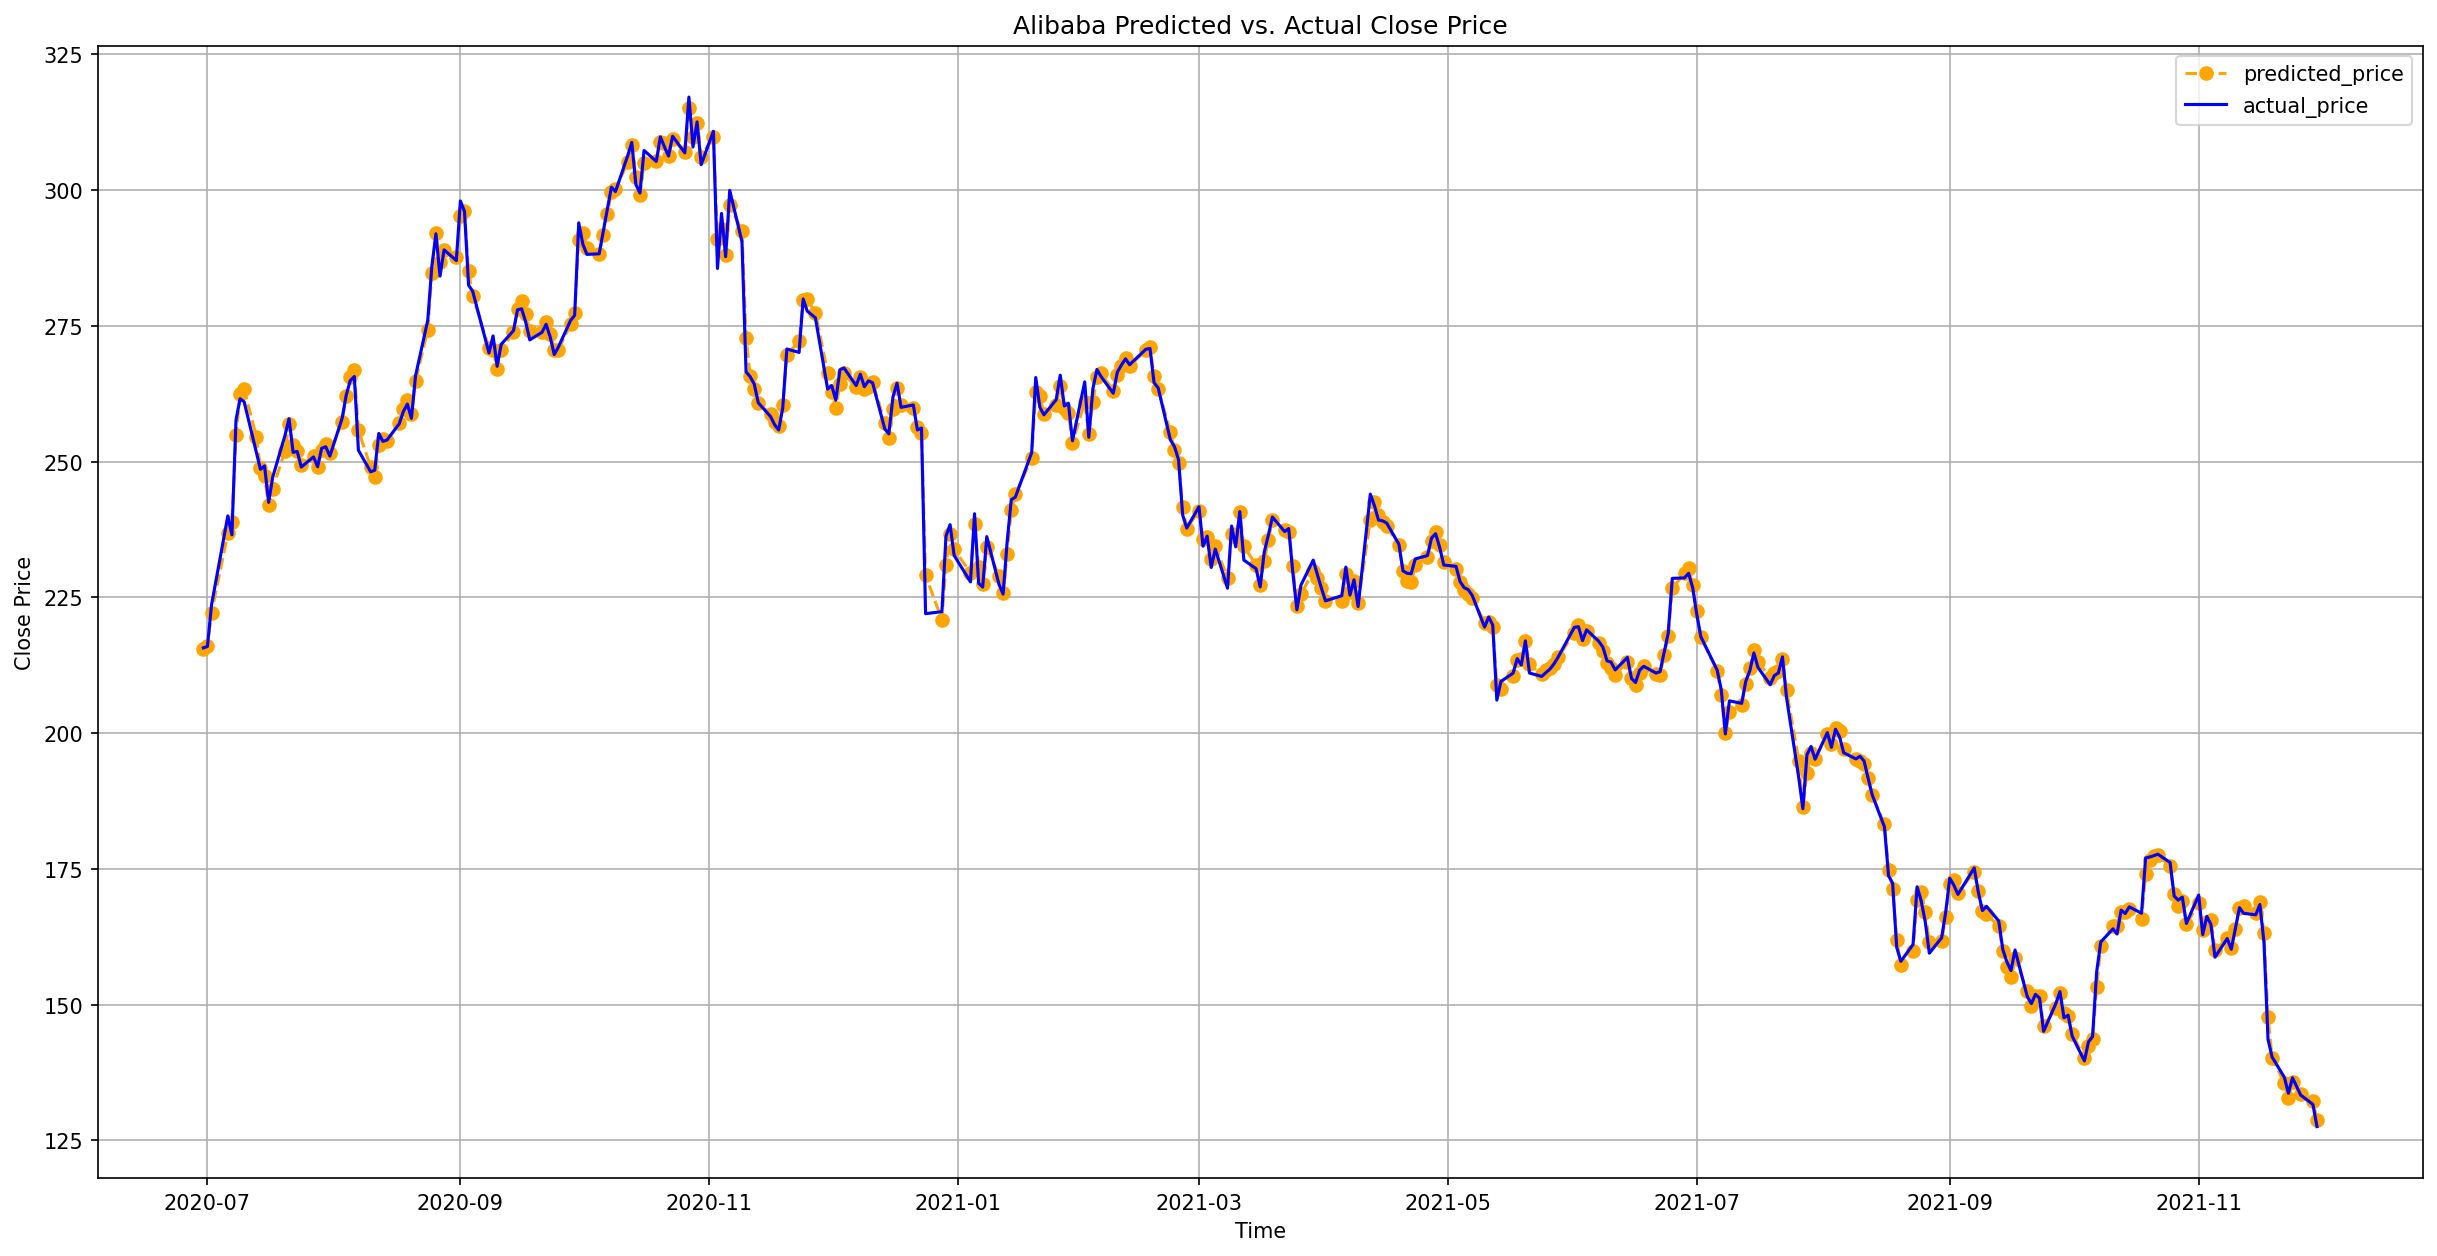

In [18]:
fig, ax = plt.subplots(figsize=(20,10), dpi=150)
ax.plot(predicted_price, color='orange', marker='o', linestyle='dashed', label='predicted_price')
ax.plot(y_test, color='blue', label='actual_price')

plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Alibaba Predicted vs. Actual Close Price')
plt.grid()
plt.show()